First, we import neccessary libraries.

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import shutil

matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'

%matplotlib inline

# Creating Fake Data
Here we create a fake data $x$ and $y$. The fake data we will use is a Gaussian function with some additive Gaussian noise.
$$
y = A \exp\left[-\frac{(x-x_0)^2}{2\sigma^2}\right] + \nu
$$
where
$$
\nu \sim \mathcal{N}(0, \alpha A)
$$
The function has 3 parameters: $A$, $x_0$ and $\sigma$, and $\alpha$ is the noise level. We will pretend that we do not know these parameters and can only observe the $x$ and $y$ data. Later we will try to estimate the function parameters.

In [2]:
def fake_data(num=1000, noise=0.2):
    """Generates fake data.

    Generates fake data with x in [-10, 10] and y follows
        y = A * exp((x-x0)^2 / 2sigma^2) + nu
    where nu is an additive Gaussian noise
        nu ~ N(0, noise * A)

    Args:
        num (int): Number of data points to generate.
        noise (float): Noise level.

    Returns:
        tuple: (data, parameters)
        
        data is a tuple (x, y). Both of them are numpy array.
        parameters is a tuple (A, x0, sigma).

    """
    A = np.random.uniform(1, 10, [])
    x0 = np.random.uniform(-10, 10, [])
    sigma = np.random.uniform(0.5, 5, [])
    x = np.linspace(-10, 10, num)
    y = A * np.exp(-(x-x0)**2 / (2*sigma**2))
    y += np.random.normal(0, noise * A, y.shape)
    return (x, y), (A, x0, sigma)

Here we run the `fake_data` function to generate the ground truth parameters and the data.

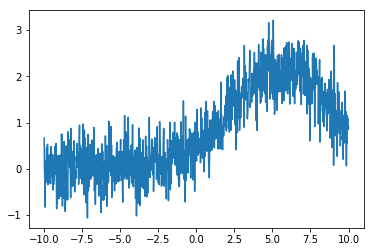

In [11]:
(data_x, data_y), (A_truth, x0_truth, sigma_truth) = fake_data()
plt.plot(data_x, data_y)

# TensorFlow Graph
Now, let's create a tensorflow graph and define a model which we will use to fit the data. The graph should have a placeholder to take $x$ as an input. Also, it should defines tensorflow variables for the parameters $A$, $x_0$ and $\sigma$. Finally, it should have a node which computes $y$.

<br>
<font color=red>__EXERCISE 1.1: Finish defining the model__</font>

In [18]:
g = tf.Graph()
with g.as_default(): 
    x = tf.placeholder(dtype=tf.float32, name='x')
    with tf.variable_scope('model', values=[x]):
        A = tf.get_variable('A', shape=[], dtype=tf.float32, initializer=tf.constant_initializer(1))
        
        x0 = tf.get_variable('x0',shape=[], dtype=tf.float32, initializer=tf.constant_initializer(1))
        sigma = tf.get_variable('s',shape=[], dtype=tf.float32, initializer=tf.constant_initializer(1))
        y = A * tf.exp(-(x-x0)**2 / (2*sigma**2))
        # EXERCISE 1.1: Finish defining the model.
        # x0 = ...
        # sigma = ...
        # y = ...

        init_op = tf.global_variables_initializer()

The code below writes the graph into the log directory (default to `./log`). TensorBoard should not be launched before running the code below.

In [19]:
if os.path.exists('./log'):
    shutil.rmtree('./log')
writer = tf.summary.FileWriter("./log", g)

Now let's run TensorBoard to view the graph by running the command:
> `tensorboard --logdir=PATH_TO_LOGDIR`

Then, view the TensorBoard in the browser by going to:
> `localhost:6006`

<br>
<font color=red>
__QUESTION 1.1: Does the TensorFlow graph look sensible to you? Can you find $A$, $x_0$ and $\sigma$ variables in the graph?__
</font>

Next, let's run our model with `data_x` we have generated and plot the result. Here the graph shows a Gaussian function with the initialized parameters $A$, $x_0$ and $\sigma$. Note here that the `init_op` need to be run to initialize the parameter variables. 

<br>
<font color=red>
__EXERCISE 1.2: Run the model to get $y$ and plot it against $x$.__
</font>

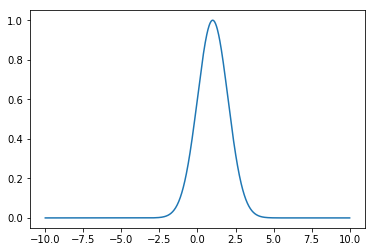

In [24]:
sess = tf.Session(graph=g)
sess.run(init_op)

# EXERCISE 1.2: Run the model to get y and plot it against x.
# y_result = ...
y_result = sess.run(y, feed_dict={x: data_x})

plt.plot(data_x, y_result)

## Gradients
Before fitting the data, let's take a side step and explore gradient computation in Tensorflow. The op for gradient computation can be created with `tf.gradients`. In the example below, we add an op which takes gradient of $y$ with respect to $x$ into the same TensorFlow graph we have created above. Also, we try computing the gradient and the gradient. Then, we plot the result.

In [ ]:
with g.as_default():
    with tf.name_scope('derivatives', values=[y, x]):
        dydx = tf.gradients(y, x)
        d2ydx2 = tf.gradients(dydx, x)
writer.add_graph(g)
dydx_result = sess.run(dydx, feed_dict={x: data_x})[0].flatten()
d2ydx2_result = sess.run(d2ydx2, feed_dict={x: data_x})[0].flatten()

plt.plot(data_x, y_result)
plt.plot(data_x, dydx_result)
plt.plot(data_x, d2ydx2_result)

If we refresh the TensorBoard, we should see new nodes in the graph for computing derivaties.

<br>
<font color=red>
__QUESTION 1.2: Does the plot look sensible to you?__ <br>
__QUESTION 1.3: Can you find automatic differentiation (chain-rule) nodes in the TensorFlow graph?__
</font>

## Fitting the Data
Next, we will try to fit our model to the (noisy) data generated. First, let's plot $y$ from the data and from the model for comparison. Currently, the model and the data does not agree at all.

In [ ]:
plt.plot(data_x, data_y)
plt.plot(data_x, y_result)

We will add nodes to the TensorFlow graph needed for optimizing the model parameters using a gradient based method. We also add summary nodes in order to view the evolution of the model parameters in TensorBoard. The `global_step` variable is used for keeping track of the number of steps we train the model. Note that `trainble` needs to be set to `False` for the `global_step` so the optimizer knows not to update this variable (normally the optimizer updates all trainable variables). Also, since we introduce a new variable, we need to redefine the `init_op` for initializing all variables in a session.

<br>
<font color=red>
__EXERCISE 1.3: Define the model loss and an op for training the model.__
</font>

In [ ]:
with g.as_default():
    global_step = tf.Variable(0, trainable=False, name='global_step')
    with tf.name_scope('training', values=[global_step, y]):
        y_actual = tf.placeholder(dtype=tf.float32, name='y_actual')
        
        # EXERCISE 1.3: Define the model loss and an op for training the model.
        # loss = ...
        # optimizer = ...
        # train_op = ...
    
    loss_summary = tf.summary.scalar('loss', loss)
    A_summary = tf.summary.scalar('A', A)
    x0_summary = tf.summary.scalar('x0', x0)
    sigma_summary = tf.summary.scalar('sigma', sigma)
    init_op = tf.global_variables_initializer()
    summary_op = tf.summary.merge_all()

writer.add_graph(g)

Again if we refresh the TensorBoard now, we should see the nodes for model optimization added to the graph.

Now, let's run the optimization.

<br>
<font color=red>
__EXERCISE 1.4: Run the train op and produce summary.__
</font>

In [ ]:
MAX_STEPS = 500
sess.run(init_op)
while (True):
    i = sess.run(global_step)
    
    _, summary = 
    # EXERCISE 1.4: Run the train op and produce summary.
    # _, summary = ...
    
    writer.add_summary(summary, i)
    if i % 100 == 0:
        print(i)
    if i > MAX_STEPS:
        break
writer.close()

Finally, our model is optimized and let's compare $y$ from the data with one predicted by the model. Also, compare the ground truth parameters to ones optimized by our model. The evolution of the model loss and model parameters can be found in TensorBoard scalar tab.

<br>
<font color=red>
__QUESTION 1.4: How do the model parameters compare to the ground truth?__ <br>
__QUESTION 1.5: How fast do the model parameters converge? How fast does the loss decrease?__
</font>

In [ ]:
predicted_y = sess.run(y, feed_dict={x: data_x})
plt.plot(data_x, data_y)
plt.plot(data_x, predicted_y)
A_fitted, x0_fitted, sigma_fitted = sess.run([A, x0, sigma])
print('A_truth = {0}, A_fitted = {1}'.format(A_truth, A_fitted))
print('x0_truth = {0}, x0_fitted = {1}'.format(x0_truth, x0_fitted))
print('sigma_truth = {0}, sigma_fitted = {1}'.format(sigma_truth, sigma_fitted))